## 试题说明

### 任务描述
近年来，随着人工智能的发展，其在语音识别、自然语言处理、图像与视频分析等诸多领域取得了巨大成功。本次竞赛将聚焦在新闻文本的分类，利用人工智能技术，对新闻文本进行分类。要求参赛者给出一个算法或模型，对于给定的文本，检测出文本所属类别。给定文本数据，选手据此训练模型，为每个测试数据预测出最正确的类别。文本分类任务，参赛者根据原始文本数据判断其所属类别。

### 数据说明
THUCNews是根据新浪新闻RSS订阅频道2005~2011年间的历史数据筛选过滤生成，包含74万篇新闻文档（2.19 GB），均为UTF-8纯文本格式。在原始新浪新闻分类体系的基础上，重新整合划分出14个候选分类类别：财经、彩票、房产、股票、家居、教育、科技、社会、时尚、时政、体育、星座、游戏、娱乐。
格式介绍：
为了使参赛者快速进入比赛核心阶段，我们已将训练集按照“标签ID+\t+标签+\t+原文标题”的格式抽取出来，参赛者可以直接根据新闻标题进行文本分类任务，希望参赛者能够给出自己的解决方案。
训练集格式		标签ID+\t+标签+\t+原文标题
测试集格式		原文标题

### 评分标准
该任务为文本分类任务，选用准确率作为评分标准，计算公式为：
Accuracy = 分类正确数量 / 需要分类总数量

### 提交答案
试题提交，需要提交**模型代码项目版本**和**结果文件**。

要求提交结果的格式如下：
1. 每个类别的行数和测试集原始数据行数应一一对应，不可乱序
2. 输出结果应检查是否总行数为83599，否则成绩无效
3. 输出结果文件命名为result.txt，一行一个类别，样例如下：


```
游戏
财经
时政
股票
家居
科技
社会
房产
教育
星座
科技
股票
游戏
财经
时政
股票
家居
科技
社会
房产
教育
```

In [4]:
import paddle
import numpy as np
import matplotlib.pyplot as plt
import os
print(paddle.__version__)

2.4.2


In [5]:
# 读取数据集
import pandas as pd
train = pd.read_table('./data/data45260/Train.txt', sep='\t',header=None)  # 有标签的训练数据文件
test = pd.read_table('./data/data45260/Test.txt', sep='\t',header=None)    # 要进行预测的测试数据文件
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [6]:
# 添加列名
train.columns = ['id',"label","text_a"]
test.columns = [['text_a']]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83599 entries, 0 to 83598
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   (text_a,)  83599 non-null  object
dtypes: object(1)
memory usage: 653.2+ KB


In [7]:
# 训练数据类别标签分布统计
train['label'].value_counts()

科技    146637
股票    138959
体育    118444
娱乐     83369
时政     56778
社会     45765
教育     37743
财经     33389
家居     29328
游戏     21936
房产     18045
时尚     12032
彩票      6830
星座      3221
Name: label, dtype: int64

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

# 设置显示中文
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
# 设置字体大小
matplotlib.rcParams['font.size'] = 16

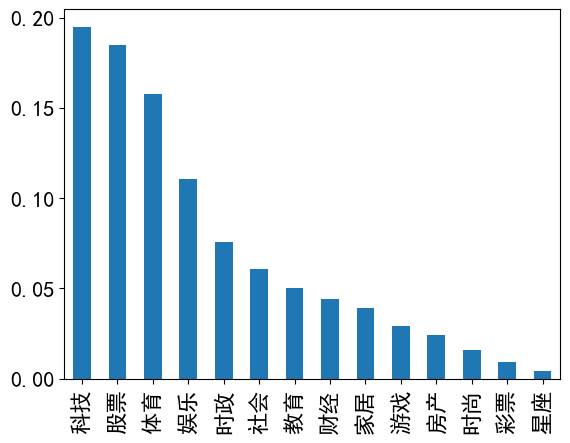

In [6]:
# 可视化类别标签分布情况
train['label'].value_counts(normalize=True).plot(kind='bar');

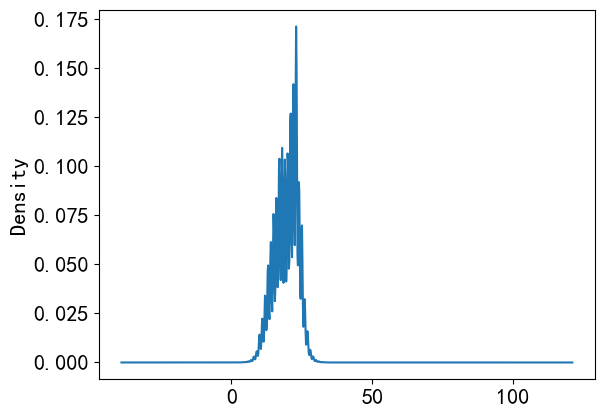

In [7]:
# 可视化训练集文本长度分布
train['text_a'].astype(str).map(len).plot(kind='kde');

In [8]:
from sklearn.utils import shuffle

new_train = pd.DataFrame()  # 定义新训练集
new_valid = pd.DataFrame()  # 定义新验证集

tags = list(train.label.unique())  # 总类别

# 根据类别进行抽样划分
for tag in tags:
    data = train[(train['label'] == tag)]
    # 抽样取0.1作为验证集
    valid_sample = data.sample(int(0.1 * len(data)))
    valid_index = valid_sample.index
    # 将剩余0.9的数据作为训练集
    all_index = data.index
    residue_index = all_index.difference(valid_index)
    residue = data.loc[residue_index]
    # 对取的数据进行保存
    new_valid = pd.concat([new_valid, valid_sample], ignore_index=True)
    new_train = pd.concat([new_train, residue], ignore_index=True)

# 对划分后的数据进行随机打乱
new_train = shuffle(new_train)
new_valid = shuffle(new_valid)

# 保存训练和验证集文件
new_train.to_csv('train.csv', sep='\t', index=False)   # 训练集
new_valid.to_csv('valid.csv', sep='\t', index=False)   # 验证集


In [9]:
import paddlehub as hub
# 设置固定随机种子便于结果的复现
seed = 1024
import random
import numpy as np
import paddle
random.seed(seed)
np.random.seed(seed)
paddle.seed(seed)

In [10]:
# 设置要求进行文本分类的14个类别
label_list=list(train.label.unique())
print(label_list)

label_map = { 
    idx: label_text for idx, label_text in enumerate(label_list)
}
print(label_map)

['财经', '彩票', '房产', '股票', '家居', '教育', '科技', '社会', '时尚', '时政', '体育', '星座', '游戏', '娱乐']
{0: '财经', 1: '彩票', 2: '房产', 3: '股票', 4: '家居', 5: '教育', 6: '科技', 7: '社会', 8: '时尚', 9: '时政', 10: '体育', 11: '星座', 12: '游戏', 13: '娱乐'}


In [11]:
!hub install roberta-wwm-ext-large

W0405 15:35:02.724821  4936 init.cc:182] Compiled with WITH_GPU, but no GPU found in runtime.
c:\program files\python38\lib\site-packages\paddle\fluid\framework.py:634: UserWarning: You are using GPU version Paddle, but your CUDA device is not set properly. CPU device will be used by default.
  warnings.warn(
[2023-04-05 15:35:06,199] [    INFO] - Module roberta-wwm-ext-large already installed in C:\Users\Deng_\.paddlehub\modules\roberta_wwm_ext_large


In [12]:
# 选择在中文领域效果较优的roberta-wwm-ext-large预训练模型并设置微调任务为14分类任务
model = hub.Module(name="roberta_wwm_ext_large", task='seq-cls', num_classes=14, label_map=label_map)

[2023-04-05 15:35:13,002] [    INFO] - We are using <class 'paddlenlp.transformers.roberta.modeling.RobertaForSequenceClassification'> to load 'hfl/roberta-wwm-ext-large'.
[2023-04-05 15:35:13,004] [    INFO] - Model config RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "cls_token_id": 101,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 

In [13]:
import os, io, csv
from paddlehub.datasets.base_nlp_dataset import InputExample, TextClassificationDataset
# 数据集存放位置路径
DATA_DIR="C:/Users/Deng_/Desktop/[NLP]中文新闻主题分类/"

In [14]:
# 对训练数据（训练集和验证集）进行格式处理，处理为模型可接受的格式
class News(TextClassificationDataset):
    def __init__(self, tokenizer, mode='train', max_seq_len=128):
        if mode == 'train':
            data_file = 'train.csv'
        elif mode == 'dev':
            data_file = 'valid.csv'
        super(News, self).__init__(
            base_path=DATA_DIR,
            data_file=data_file,
            tokenizer = tokenizer,
            max_seq_len=max_seq_len,
            mode=mode,
            is_file_with_header=True,
            label_list=label_list
            )

    # 解析文本文件里的样本
    def _read_file(self, input_file, is_file_with_header: bool = False):
        if not os.path.exists(input_file):
            raise RuntimeError("The file {} is not found.".format(input_file))
        else:
            with io.open(input_file, "r", encoding="UTF-8") as f:
                reader = csv.reader(f, delimiter="\t")  # ‘\t’分隔数据
                examples = []
                seq_id = 0
                header = next(reader) if is_file_with_header else None
                for line in reader:
                    example = InputExample(guid=seq_id, text_a=line[0], label=line[1])
                    seq_id += 1
                    examples.append(example)
                return examples

# 最大序列长度max_seq_len是可调整的重要参数-->待调整
train_dataset = News( model.get_tokenizer(), mode='train', max_seq_len=48 ) # '''
dev_dataset = News( model.get_tokenizer(), mode='dev', max_seq_len=48)

# 处理完后查看处理后的数据前3条
for e in train_dataset.examples[:3]:
    print(e)
for e in dev_dataset.examples[:3]:
    print(e)


[2023-04-05 15:35:26,070] [    INFO] - We are using <class 'paddlenlp.transformers.roberta.tokenizer.RobertaChineseTokenizer'> to load 'hfl/roberta-wwm-ext-large'.
[2023-04-05 15:35:26,072] [    INFO] - Already cached C:\Users\Deng_\.paddlenlp\models\hfl/roberta-wwm-ext-large\vocab.txt
[2023-04-05 15:35:26,085] [    INFO] - tokenizer config file saved in C:\Users\Deng_\.paddlenlp\models\hfl/roberta-wwm-ext-large\tokenizer_config.json
[2023-04-05 15:35:26,087] [    INFO] - Special tokens file saved in C:\Users\Deng_\.paddlenlp\models\hfl/roberta-wwm-ext-large\special_tokens_map.json
[2023-04-05 15:36:30,015] [    INFO] - We are using <class 'paddlenlp.transformers.roberta.tokenizer.RobertaChineseTokenizer'> to load 'hfl/roberta-wwm-ext-large'.
[2023-04-05 15:36:30,017] [    INFO] - Already cached C:\Users\Deng_\.paddlenlp\models\hfl/roberta-wwm-ext-large\vocab.txt
[2023-04-05 15:36:30,041] [    INFO] - tokenizer config file saved in C:\Users\Deng_\.paddlenlp\models\hfl/roberta-wwm-ext-l

text=4	label=家居
text=9	label=时政
text=6	label=科技
text=9	label=时政
text=6	label=科技
text=13	label=娱乐


In [15]:
import paddle
# 优化器的选择
optimizer = paddle.optimizer.AdamW(learning_rate=2e-4, weight_decay=0.0, parameters=model.parameters())
# 训练运行配置
trainer = hub.Trainer(model, optimizer, checkpoint_dir='./ckpt', use_gpu=True, use_vdl=True)

[2023-04-05 15:36:43,576] [ WARNING] - PaddleHub model checkpoint not found, start from scratch...


In [ ]:
# 模型训练：配置训练参数，指定验证集，启动训练
trainer.train(train_dataset, epochs=4, batch_size=256, eval_dataset=dev_dataset, save_interval=1)

In [ ]:
# 对测试集进行预测：
import numpy as np
# 将输入数据进行格式处理，处理为list格式
data_array = np.array(test)
data_list =data_array.tolist()

# 加载训练好的模型
model = hub.Module(
    name="roberta-wwm-ext-large", 
    task='seq-cls', 
    load_checkpoint='./ckpt/best_model/model.pdparams',  # 加载最优一轮的模型参数
    num_classes=14, 
    label_map=label_map)

# 对测试集数据进行预测:
predictions = model.predict(data_list, max_seq_len=48, batch_size=32, use_gpu=True)

In [ ]:
# 预测结果存储为要求格式 txt文件
def write_results(labels, file_path):
    with open(file_path, "w", encoding="utf8") as f:
        f.writelines("\n".join(labels))

write_results(predictions, "./result.txt")

In [ ]:
# # 移动提交结果文件至主目录下
# !cp -r ./data/data45260/result.txt ./